In [37]:
pip install colour-science

In [38]:
import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import colour

SEED = 42

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("GPU:", torch.cuda.get_device_name(0) if device == "cuda" else "None")



Device: cuda
GPU: Tesla T4


In [39]:
NUM_PATCHES = 128
H, W = 16, 16
INK_CH = 7
LATENT_DIM = 32

BATCH_SIZE = 16
NUM_STEPS = 300

ALPHA_APP = 0.1
BETA_MAX = 1.0
WARMUP_STEPS = 300
HINGE_WT = 0.1
NOISE_STD = 0.05
HINGE_MARGIN = 0.03
LAMBDAS = torch.tensor([0.1, 0.5, 0.9], device=device)


In [40]:
class ICCAppearanceEngine:
    @torch.no_grad()
    def cmyk_to_lab(self, Y):
        C, M, Yc, K = Y[:,0], Y[:,1], Y[:,2], Y[:,3]

        R = (1 - C) * (1 - K)
        G = (1 - M) * (1 - K)
        B = (1 - Yc) * (1 - K)

        rgb = torch.stack([R, G, B], dim=-1)
        rgb = rgb.clamp(0,1).cpu().numpy()

        labs = []
        for i in range(rgb.shape[0]):
            xyz = colour.sRGB_to_XYZ(rgb[i])
            lab = colour.XYZ_to_Lab(xyz)
            labs.append(lab)

        lab = torch.from_numpy(np.stack(labs)).permute(0,3,1,2)
        return lab.to(Y.device, dtype=Y.dtype)

icc_engine = ICCAppearanceEngine()


In [41]:
class SimpleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(INK_CH * H * W, 2 * LATENT_DIM)

    def forward(self, y):
        y = y.view(y.size(0), -1)
        mu, logvar = self.fc(y).chunk(2, dim=1)
        return mu, logvar

encoder = SimpleEncoder().to(device)


In [42]:
class SimpleDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_DIM + 1, 256)
        self.fc2 = nn.Linear(256, INK_CH * H * W)

    def forward(self, z, lam):
        lam = lam.view(-1, 1)
        z = torch.cat([z, lam], dim=1)
        h = F.silu(self.fc1(z))
        y = self.fc2(h)
        return torch.sigmoid(y.view(-1, INK_CH, H, W))

decoder = SimpleDecoder().to(device)
print(decoder)  # sanity check


SimpleDecoder(
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1792, bias=True)
)


In [43]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std



In [44]:
def jitter_lambda(lam, eps=0.03):
    """
    Adds small Gaussian noise to lambda for robustness.
    lam: (B,) tensor
    eps: jitter strength (keep small!)
    """
    return lam + eps * torch.randn_like(lam)


In [45]:
def loss_ink_recon(Y_pred, Y_tgt):
    w = torch.tensor([1,1,1,1,0.3,0.3,0.3], device=Y_pred.device)
    diff = F.smooth_l1_loss(Y_pred, Y_tgt, reduction="none")
    return (diff * w.view(1,-1,1,1)).mean()

def loss_appearance_icc(Y_pred, Y_tgt):
    with torch.no_grad():
        Lab_tgt = icc_engine.cmyk_to_lab(Y_tgt)
    Lab_pred = icc_engine.cmyk_to_lab(Y_pred)
    return F.smooth_l1_loss(Lab_pred, Lab_tgt)

def loss_kl_beta(mu, logvar, step, warmup_steps=1000, beta_max=1.0):
    beta = beta_max * min(step / warmup_steps, 1.0)
    kl = 0.5 * torch.mean(
        mu.pow(2) + logvar.exp() - logvar - 1.0
    )
    return beta * kl


def ogv_usage(Y):
    return Y[:,4:7].mean(dim=(1,2,3))



def hinge_lambda_penalty(Y_safe, Y_mid, Y_sat):
    u_safe = ogv_usage(Y_safe)
    u_mid  = ogv_usage(Y_mid)
    u_sat  = ogv_usage(Y_sat)

    return (
        F.relu(u_safe - u_mid + HINGE_MARGIN).mean() +
        F.relu(u_mid  - u_sat + HINGE_MARGIN).mean()
    )



In [46]:
Y_targets = torch.rand(NUM_PATCHES, INK_CH, H, W, device=device)


In [47]:
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-3
)


In [48]:
ink_losses, app_losses, kl_losses, hinge_losses = [], [], [], []

for step in range(NUM_STEPS):
    seed_all(SEED + step)

    idx = torch.randint(0, NUM_PATCHES, (BATCH_SIZE,), device=device)
    Y_tgt = Y_targets[idx]

    noise = NOISE_STD * torch.randn_like(Y_tgt)
    Y_noisy = torch.clamp(Y_tgt + noise, 0, 1)

    mu, logvar = encoder(Y_noisy)
    z = reparameterize(mu, logvar)

    lam_safe = jitter_lambda(LAMBDAS[0].expand(z.size(0)))
    lam_mid  = jitter_lambda(LAMBDAS[1].expand(z.size(0)))
    lam_sat  = jitter_lambda(LAMBDAS[2].expand(z.size(0)))

    Y_safe = decoder(z, lam_safe)
    Y_mid  = decoder(z, lam_mid)
    Y_sat  = decoder(z, lam_sat)


    L_ink = (
        loss_ink_recon(Y_safe, Y_tgt) +
        loss_ink_recon(Y_mid,  Y_tgt) +
        loss_ink_recon(Y_sat,  Y_tgt)
    ) / 3

    L_app = (
        loss_appearance_icc(Y_safe, Y_tgt) +
        loss_appearance_icc(Y_mid,  Y_tgt) +
        loss_appearance_icc(Y_sat,  Y_tgt)
    ) / 3

    L_kl = loss_kl_beta(
    mu,
    logvar,
    step,
    warmup_steps=WARMUP_STEPS,
    beta_max=BETA_MAX
    )

    L_hinge = hinge_lambda_penalty(Y_safe, Y_mid, Y_sat)



    L_total = (
    L_ink +
    ALPHA_APP * L_app +
    L_kl +                  # β(t) already inside
    HINGE_WT * L_hinge
    )


    optimizer.zero_grad()
    L_total.backward()
    optimizer.step()

    ink_losses.append(L_ink.item())
    app_losses.append(L_app.item())
    kl_losses.append(L_kl.item())
    hinge_losses.append(L_hinge.item())

    if step % 50 == 0:
        print(f"{step:03d} | ink={L_ink:.4f} | app={L_app:.4f} | kl={L_kl:.4f}")


000 | ink=0.0300 | app=19.5296 | kl=0.0000
050 | ink=0.0292 | app=19.0983 | kl=0.0017
100 | ink=0.0292 | app=19.1965 | kl=0.0018
150 | ink=0.0291 | app=19.2439 | kl=0.0023
200 | ink=0.0291 | app=19.3398 | kl=0.0031
250 | ink=0.0287 | app=19.0631 | kl=0.0041


In [49]:
def run_single_epoch(steps=100):
    decoder.train()
    encoder.train()
    stats = []

    for step in range(steps):
        idx = torch.randint(0, NUM_PATCHES, (BATCH_SIZE,), device=device)
        Y_tgt = Y_targets[idx]

        mu, logvar = encoder(Y_tgt)
        z = reparameterize(mu, logvar)

        Y = decoder(z, LAMBDAS[1].expand(z.size(0)))  # mid λ

        L_kl = loss_kl_beta(mu, logvar, step)

        loss = (
            loss_ink_recon(Y, Y_tgt) +
            ALPHA_APP * loss_appearance_icc(Y, Y_tgt) +
            L_kl
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        stats.append(loss.item())

    return sum(stats) / len(stats)


print("Epoch loss:", run_single_epoch())


Epoch loss: 1.9418082022666932


In [50]:
def epoch_mean(x):
    return sum(x) / len(x)


In [51]:
def epoch_train_ink(num_epochs=10, steps_per_epoch=50):
    ink_epoch = []

    for ep in range(num_epochs):
        encoder.train()
        decoder.train()

        vals = []
        for _ in range(steps_per_epoch):
            idx = torch.randint(0, NUM_PATCHES, (BATCH_SIZE,), device=device)
            Y_tgt = Y_targets[idx]

            noise = NOISE_STD * torch.randn_like(Y_tgt)
            Y_noisy = torch.clamp(Y_tgt + noise, 0, 1)

            mu, logvar = encoder(Y_noisy)
            z = reparameterize(mu, logvar)

            lam = LAMBDAS[1].expand(z.size(0))
            Y = decoder(z, lam)

            loss = loss_ink_recon(Y, Y_tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            vals.append(loss.item())

        epoch_loss = sum(vals) / len(vals)
        ink_epoch.append(epoch_loss)
        print(f"Epoch {ep:02d} | Ink = {epoch_loss:.4f}")

    return ink_epoch


Epoch 00 | Ink = 0.0289
Epoch 01 | Ink = 0.0289
Epoch 02 | Ink = 0.0289
Epoch 03 | Ink = 0.0289
Epoch 04 | Ink = 0.0288
Epoch 05 | Ink = 0.0288
Epoch 06 | Ink = 0.0287
Epoch 07 | Ink = 0.0286
Epoch 08 | Ink = 0.0285
Epoch 09 | Ink = 0.0283


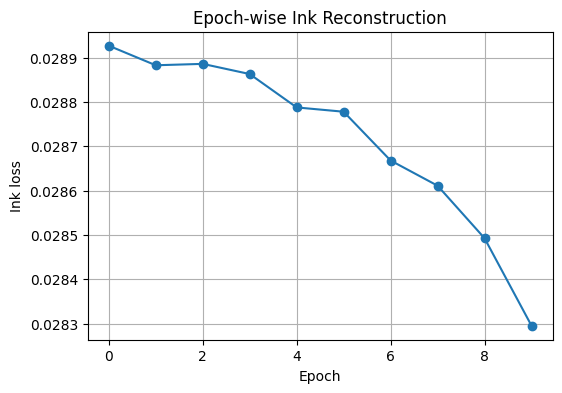

In [52]:
ink_epoch = epoch_train_ink()

plt.figure(figsize=(6,4))
plt.plot(ink_epoch, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Ink loss")
plt.title("Epoch-wise Ink Reconstruction")
plt.grid(True)
plt.show()


In [53]:
def epoch_test_appearance(num_epochs=10, steps_per_epoch=50):
    app_epoch = []

    for ep in range(num_epochs):
        vals = []
        for _ in range(steps_per_epoch):
            idx = torch.randint(0, NUM_PATCHES, (BATCH_SIZE,), device=device)
            Y_tgt = Y_targets[idx]

            mu, logvar = encoder(Y_tgt)
            z = reparameterize(mu, logvar)

            lam = LAMBDAS[1].expand(z.size(0))
            Y = decoder(z, lam)

            vals.append(loss_appearance_icc(Y, Y_tgt).item())

        app_epoch.append(epoch_mean(vals))
        print(f"Epoch {ep:02d} | App = {app_epoch[-1]:.2f}")

    return app_epoch


Epoch 00 | App = 18.77
Epoch 01 | App = 18.80
Epoch 02 | App = 18.87
Epoch 03 | App = 18.80
Epoch 04 | App = 18.80
Epoch 05 | App = 18.81
Epoch 06 | App = 18.80
Epoch 07 | App = 18.78
Epoch 08 | App = 18.81
Epoch 09 | App = 18.79


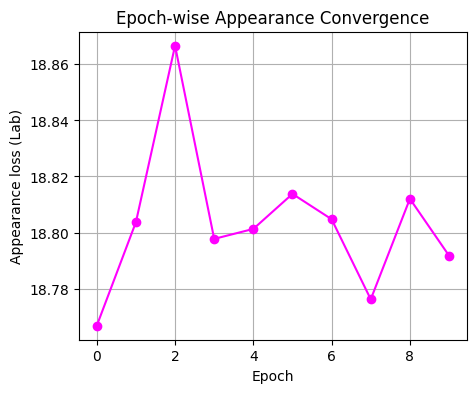

In [54]:
app_epoch = epoch_test_appearance()

plt.figure(figsize=(5,4))
plt.plot(app_epoch, marker="o", color="magenta")
plt.xlabel("Epoch")
plt.ylabel("Appearance loss (Lab)")
plt.title("Epoch-wise Appearance Convergence")
plt.grid(True)
plt.show()


In [55]:
def epoch_test_kl(num_epochs=10, steps_per_epoch=50):
    kl_epoch = []

    for ep in range(num_epochs):
        vals = []
        for step in range(steps_per_epoch):
            idx = torch.randint(0, NUM_PATCHES, (BATCH_SIZE,), device=device)
            Y_tgt = Y_targets[idx]

            mu, logvar = encoder(Y_tgt)
            global_step = ep * steps_per_epoch + step

            vals.append(
                loss_kl_beta(mu, logvar, global_step).item()
            )

        kl_epoch.append(epoch_mean(vals))
        print(f"Epoch {ep:02d} | KL = {kl_epoch[-1]:.5f}")

    return kl_epoch


Epoch 00 | KL = 0.01898
Epoch 01 | KL = 0.05768
Epoch 02 | KL = 0.09646
Epoch 03 | KL = 0.13506
Epoch 04 | KL = 0.17408
Epoch 05 | KL = 0.21251
Epoch 06 | KL = 0.25122
Epoch 07 | KL = 0.29002
Epoch 08 | KL = 0.32866
Epoch 09 | KL = 0.36719


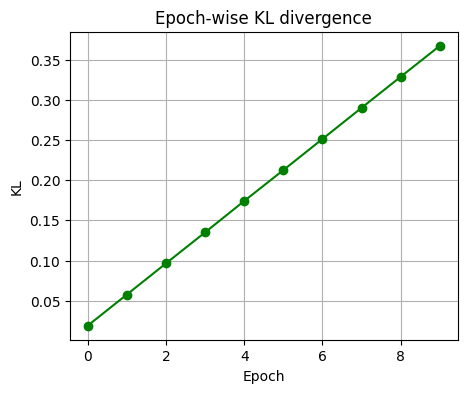

In [56]:
kl_epoch = epoch_test_kl()

plt.figure(figsize=(5,4))
plt.plot(kl_epoch, marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("KL")
plt.title("Epoch-wise KL divergence")
plt.grid(True)
plt.show()


In [57]:
def epoch_train_full_text(
    num_epochs=10,
    steps_per_epoch=50
):
    print("Epoch |   Ink    | Appearance |    KL     |  Hinge")
    print("----------------------------------------------------")

    for ep in range(num_epochs):
        encoder.train()
        decoder.train()

        ink_vals, app_vals, kl_vals, hinge_vals = [], [], [], []

        for step in range(steps_per_epoch):
            global_step = ep * steps_per_epoch + step

            idx = torch.randint(0, NUM_PATCHES, (BATCH_SIZE,), device=device)
            Y_tgt = Y_targets[idx]

            noise = NOISE_STD * torch.randn_like(Y_tgt)
            Y_noisy = torch.clamp(Y_tgt + noise, 0, 1)

            mu, logvar = encoder(Y_noisy)
            z = reparameterize(mu, logvar)

            Y_safe = decoder(z, LAMBDAS[0].expand(z.size(0)))
            Y_mid  = decoder(z, LAMBDAS[1].expand(z.size(0)))
            Y_sat  = decoder(z, LAMBDAS[2].expand(z.size(0)))

            L_ink = (
                loss_ink_recon(Y_safe, Y_tgt) +
                loss_ink_recon(Y_mid,  Y_tgt) +
                loss_ink_recon(Y_sat,  Y_tgt)
            ) / 3.0

            L_app = (
                loss_appearance_icc(Y_safe, Y_tgt) +
                loss_appearance_icc(Y_mid,  Y_tgt) +
                loss_appearance_icc(Y_sat,  Y_tgt)
            ) / 3.0

            L_kl = loss_kl_beta(mu, logvar, global_step)
            L_hinge = hinge_lambda_penalty(Y_safe, Y_mid, Y_sat)

            L_total = (
                L_ink +
                ALPHA_APP * L_app +
                L_kl +
                HINGE_WT * L_hinge
            )

            optimizer.zero_grad()
            L_total.backward()
            optimizer.step()

            ink_vals.append(L_ink.item())
            app_vals.append(L_app.item())
            kl_vals.append(L_kl.item())
            hinge_vals.append(L_hinge.item())

        print(
            f"{ep:05d} | "
            f"{np.mean(ink_vals):.5f} | "
            f"{np.mean(app_vals):.3f}     | "
            f"{np.mean(kl_vals):.5f} | "
            f"{np.mean(hinge_vals):.6f}",
            flush=True
        )


In [58]:
epoch_train_full_text(num_epochs=10, steps_per_epoch=50)


Epoch |   Ink    | Appearance |    KL     |  Hinge
----------------------------------------------------
00000 | 0.02870 | 19.131     | 0.00181 | 0.000004
00001 | 0.02883 | 19.169     | 0.00105 | 0.000008
00002 | 0.02903 | 19.158     | 0.00066 | 0.000008
00003 | 0.02902 | 19.194     | 0.00032 | 0.000003
00004 | 0.02905 | 19.131     | 0.00029 | 0.000003
00005 | 0.02902 | 19.138     | 0.00038 | 0.000001
00006 | 0.02900 | 19.118     | 0.00059 | 0.000002
00007 | 0.02895 | 19.076     | 0.00086 | 0.000002
00008 | 0.02898 | 19.096     | 0.00151 | 0.000002
00009 | 0.02895 | 19.105     | 0.00239 | 0.000001
